# ADS Thesis Project - Updated Ratio and trust Variables 

**Authors: Marion Späth (2772981)**


This notebook documents the persisting issues with the updated ratio variable and investigates the new trsut variables using the goat data.

In [1]:
#!pip install shap
#! pip install catboost
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import os

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from catboost import CatBoostRegressor, Pool

# with pickle we can save the model, helps with long computation times
import pickle

### Import datasets

In [2]:
pd.set_option('display.max_columns', None) # show all columns in output

# set working directory
os.chdir('C:/Users/Marion Späth/Desktop/ADS/Thesis/Data/ML_training')

# load train and test data (previously created in the ElasticNet notebook)
train_goat = pd.read_csv("train_goat_df.csv")
test_goat = pd.read_csv("test_goat_df.csv")
test_goat.head(2)

,id,wave,afm_language,age_constant,agric_land,amh_language,educ_recoded_constant,educ_recoded_constant_num,eng_language,expend,irrigated_land_bin,cs_cs_diff_post_goat,cs_cs_ratio_post_goat,number_minors,educ_child_recoded,educ_child_recodedNUMERIC,activity_child_recoded,household_description,number_adults,main_info_source_recoded,religion_recoded,owns_phone,household_moved,why_not_purchase_recoded,know_vip,trust_vip,age_constant_z,number_adults_z,number_minors_z,educ_child_z,educ_adult_z,cs_diff_log,resid_mixed
0,4,4,No,35,Yes,No,Never attended,1,No,0,0,-53.165897,0.0,3,Elementary,7,Student,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes,-0.488589,-0.191439,-0.140337,0.922786,-0.474056,3.992052,-0.781516
1,12,4,No,30,No,No,Never attended,1,No,0,0,-115.108932,0.0,3,Never attended school,0,Working with Livestock,Fully settled: The whole of the household (all...,3,Interpersonal Sources,Christian,0,Yes,Lack of Awareness or Understanding,No,No,-0.786820,0.582578,-0.140337,-0.899432,-0.474056,4.754529,-0.050775


In [5]:
list(new_df.columns)

['hhid_r4',
 'id',
 'buy_nr_cattle_r4',
 'buy_cattle_r4',
 'buy_nr_goat_r4',
 'buy_goat_r4',
 'n_previd_cattle_r4',
 'n_previd_goat_r4',
 'cs_cs_diff_post_cattle_r4',
 'cs_cs_ratio_post_cattle_r4',
 'cs_ce_ratio_post_cattle_r4',
 'cs_cs_diff_post_goat_r4',
 'cs_cs_ratio_post_goat_r4',
 'cs_ce_ratio_post_goat_r4',
 'round_r4',
 'hhid_r3',
 'buy_nr_cattle_r3',
 'buy_cattle_r3',
 'buy_nr_goat_r3',
 'buy_goat_r3',
 'n_previd_cattle_r3',
 'n_previd_goat_r3',
 'cs_cs_diff_post_cattle_r3',
 'cs_cs_ratio_post_cattle_r3',
 'cs_ce_ratio_post_cattle_r3',
 'cs_cs_diff_post_goat_r3',
 'cs_cs_ratio_post_goat_r3',
 'cs_ce_ratio_post_goat_r3',
 'round_r3',
 'hhid_r2',
 'buy_nr_cattle_r2',
 'buy_cattle_r2',
 'buy_nr_goat_r2',
 'buy_goat_r2',
 'n_previd_cattle_r2',
 'n_previd_goat_r2',
 'cs_cs_diff_post_cattle_r2',
 'cs_cs_ratio_post_cattle_r2',
 'cs_ce_ratio_post_cattle_r2',
 'cs_cs_diff_post_goat_r2',
 'cs_cs_ratio_post_goat_r2',
 'cs_ce_ratio_post_goat_r2',
 'round_r2',
 's3_q7_r4',
 's3_q7_0_r4',
 '

Select variables and merge.

In [76]:
new_df = pd.read_excel("all_y_v3.xlsx")
new_df

new_col = new_df[["id", "buy_goat_r4", "buy_goat_r3", "buy_goat_r2", "n_previd_goat_r4", "n_previd_goat_r3", "n_previd_goat_r2",  "cs_ce_ratio_post_goat_r4", "cs_ce_ratio_post_goat_r3",
                  "cs_ce_ratio_post_goat_r2", "vip_trust_scale_r2", "vip_trust_scale_r3", "vip_trust_scale_r4", "vip_trust_advice_r2", "vip_trust_advice_r3", "vip_trust_advice_r4",
                  "vip_trust_money_r2", "vip_trust_money_r3", "vip_trust_money_r4",
                  "cs_cs_ratio_post_goat_r4", "cs_cs_ratio_post_goat_r3", "cs_cs_ratio_post_goat_r2"]]

In [96]:
# Transform dataframe form wide format into long format (i.e., resulting df has one row per individual-wave)
df_long = pd.wide_to_long(
    new_col,
    stubnames=["buy_goat", "n_previd_goat", "cs_cs_ratio_post_goat", "cs_ce_ratio_post_goat", "vip_trust_scale", "vip_trust_money", "vip_trust_advice"],
    i="id",
    j="wave",
    sep="_r"
).reset_index()

df_long["welfare_ratio"] = np.where(df_long['buy_goat']=="Not buy", df_long["cs_ce_ratio_post_goat"], df_long["cs_cs_ratio_post_goat"]) 

full_ratio = df_long[(df_long["welfare_ratio"].notna()) &( df_long["n_previd_goat"]>0)]
full_ratio

,id,wave,buy_goat,n_previd_goat,cs_cs_ratio_post_goat,cs_ce_ratio_post_goat,vip_trust_scale,vip_trust_money,vip_trust_advice,welfare_ratio
0,1,4,Not buy,10,0.0,0.992172,3.50,2.5,4.5,0.992172
1,2,4,Not buy,10,0.0,0.972470,7.00,8.5,5.5,0.972470
2,3,4,Not buy,15,0.0,0.957651,7.00,5.0,9.0,0.957651
3,4,4,Not buy,5,0.0,0.997209,5.50,5.5,5.5,0.997209
4,5,4,Not buy,12,0.0,0.975139,4.00,4.0,4.0,0.975139
...,...,...,...,...,...,...,...,...,...,...
7243,2412,2,Not buy,20,NaN,1.000000,6.75,6.0,7.5,1.000000
7244,2413,2,Not buy,3,NaN,1.000000,10.00,10.0,10.0,1.000000
7245,2414,2,Not buy,3,NaN,1.000000,6.75,6.0,7.5,1.000000
7246,2415,2,Not buy,6,NaN,1.000000,8.50,8.0,9.0,1.000000


There are still rows where household bought insurance, but has no cs_cs_value.

In [113]:
test = full_ratio[full_ratio["welfare_ratio"]<0.3]
test

,id,wave,buy_goat,n_previd_goat,cs_cs_ratio_post_goat,cs_ce_ratio_post_goat,vip_trust_scale,vip_trust_money,vip_trust_advice,welfare_ratio
134,135,4,Buy,4,0.284577,0.998724,1.50,1.0,2.0,0.284577
149,150,4,Buy,8,0.123899,0.972465,4.75,4.5,5.0,0.123899
573,574,4,Buy,7,0.288343,0.977816,2.75,2.5,3.0,0.288343
604,605,4,Buy,4,0.250266,0.991553,5.50,5.5,5.5,0.250266
605,606,4,Buy,5,0.186858,0.999423,6.50,7.0,6.0,0.186858
...,...,...,...,...,...,...,...,...,...,...
6105,1274,2,Buy,10,0.257789,0.943125,3.00,3.0,3.0,0.257789
6140,1309,2,Buy,12,0.246621,0.992785,3.00,3.5,2.5,0.246621
6147,1316,2,Buy,6,0.094593,0.983222,2.75,2.5,3.0,0.094593
6308,1477,2,Buy,15,-5.400449,0.991216,6.25,4.0,8.5,-5.400449


correlations of the trust variables.

In [25]:
r = np.corrcoef(df_long.vip_trust_scale, df_long.vip_trust_advice)
print(r)

r = np.corrcoef(df_long.vip_trust_scale, df_long.vip_trust_money)
print(r)

r = np.corrcoef(df_long.vip_trust_advice, df_long.vip_trust_money)
print(r)

[[1.        0.9164308]
 [0.9164308 1.       ]]
[[1.         0.92868166]
 [0.92868166 1.        ]]
[[1.         0.70264969]
 [0.70264969 1.        ]]


Due to very high correlations, only the vip_trust_scale will be used in the ML models.

Merge

In [47]:
train_goat = train_goat.merge(df_long, on=['id', 'wave'], how='left')
test_goat = test_goat.merge(df_long, on=['id', 'wave'], how='left')
train_goat.head(2)

,id,wave,afm_language,age_constant,agric_land,amh_language,educ_recoded_constant,educ_recoded_constant_num,eng_language,expend,irrigated_land_bin,cs_cs_diff_post_goat,cs_cs_ratio_post_goat,number_minors,educ_child_recoded,educ_child_recodedNUMERIC,activity_child_recoded,household_description,number_adults,main_info_source_recoded,religion_recoded,owns_phone,household_moved,why_not_purchase_recoded,know_vip,trust_vip,age_constant_z,number_adults_z,number_minors_z,educ_child_z,educ_adult_z,cs_diff_log,resid_mixed,buy_goat,cs_ce_ratio_post_goat,vip_trust_scale,vip_trust_money,vip_trust_advice
0,1,4,No,25,Yes,No,Never attended,1,No,0,1,-120.671875,0.0,2,Never attended school,0,Working with Livestock,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,Lack of Awareness or Understanding,Yes,Yes,-1.085051,-0.191439,-0.754558,-0.899432,-0.474056,4.801328,-0.026184,Not buy,0.992172,3.5,2.5,4.5
1,2,4,Yes,27,Yes,No,Adult Education,17,No,0,0,-758.621033,0.0,2,Never attended school,0,Not working,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes,-0.965759,-0.191439,-0.754558,-0.899432,3.478166,6.632820,1.683224,Not buy,0.972470,7.0,8.5,5.5


In [48]:
train_goat["welfare_ratio"] = np.where(train_goat['buy_goat']=="Not buy", train_goat["cs_ce_ratio_post_goat"], train_goat["cs_cs_ratio_post_goat"]) 
test_goat["welfare_ratio"] = np.where(test_goat['buy_goat']=="Not buy", test_goat["cs_ce_ratio_post_goat"], test_goat["cs_cs_ratio_post_goat"]) 
test_goat.head()

,id,wave,afm_language,age_constant,agric_land,amh_language,educ_recoded_constant,educ_recoded_constant_num,eng_language,expend,irrigated_land_bin,cs_cs_diff_post_goat,cs_cs_ratio_post_goat,number_minors,educ_child_recoded,educ_child_recodedNUMERIC,activity_child_recoded,household_description,number_adults,main_info_source_recoded,religion_recoded,owns_phone,household_moved,why_not_purchase_recoded,know_vip,trust_vip,age_constant_z,number_adults_z,number_minors_z,educ_child_z,educ_adult_z,cs_diff_log,resid_mixed,buy_goat,cs_ce_ratio_post_goat,vip_trust_scale,vip_trust_money,vip_trust_advice,welfare_ratio
0,4,4,No,35,Yes,No,Never attended,1,No,0,0,-53.165897,0.0,3,Elementary,7,Student,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes,-0.488589,-0.191439,-0.140337,0.922786,-0.474056,3.992052,-0.781516,Not buy,0.997209,5.50,5.5,5.5,0.997209
1,12,4,No,30,No,No,Never attended,1,No,0,0,-115.108932,0.0,3,Never attended school,0,Working with Livestock,Fully settled: The whole of the household (all...,3,Interpersonal Sources,Christian,0,Yes,Lack of Awareness or Understanding,No,No,-0.786820,0.582578,-0.140337,-0.899432,-0.474056,4.754529,-0.050775,Not buy,0.990984,3.50,3.5,3.5,0.990984
2,13,4,No,45,Yes,No,Never attended,1,No,0,1,-235.104538,0.0,1,Never attended school,0,Working with Livestock,Fully settled: The whole of the household (all...,4,Interpersonal Sources,Traditional/Wakefata,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes,0.107872,1.356596,-1.368778,-0.899432,-0.474056,5.464275,0.488584,Not buy,0.989149,4.50,4.0,5.0,0.989149
3,25,4,No,52,Yes,No,Never attended,1,No,1,1,-402.949158,0.0,2,Never attended school,0,Working with Livestock,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Muslim,0,No,"Financial, Practical, and Situational Constraints",Yes,Yes,0.525396,-0.191439,-0.754558,-0.899432,-0.474056,6.001289,1.124426,Not buy,0.973874,5.25,5.5,5.0,0.973874
4,30,4,No,26,No,No,Never attended,1,No,0,0,-158.495789,0.0,3,Never attended school,0,Not working,Fully settled: The whole of the household (all...,2,Interpersonal Sources,Traditional/Wakefata,0,Yes,BOUGHT INSURANCE,No,Yes,-1.025405,-0.191439,-0.140337,-0.899432,-0.474056,5.072018,0.350569,Not buy,0.988712,2.75,2.0,3.5,0.988712


Negative values:

In [98]:
full_ratio.welfare_ratio.min()

-5.400449275970459

In [99]:
full_ratio.welfare_ratio.max()

1.0

Most houshold already fullfill their potential almost completely. This can point to a ceiling effect making it hard to find patterns to close the gap. 

In [100]:
full_ratio.welfare_ratio.mean()

0.9367489368699032

(array([   0.,    7.,   12.,   22.,   21.,   24.,   30.,   43.,   22.,
          16.,   25.,   32.,   27.,   15.,   18.,   33.,   12.,    9.,
          10.,   11.,   19.,    8.,   13.,    5.,   19.,   28.,   41.,
         117.,  651., 4665.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

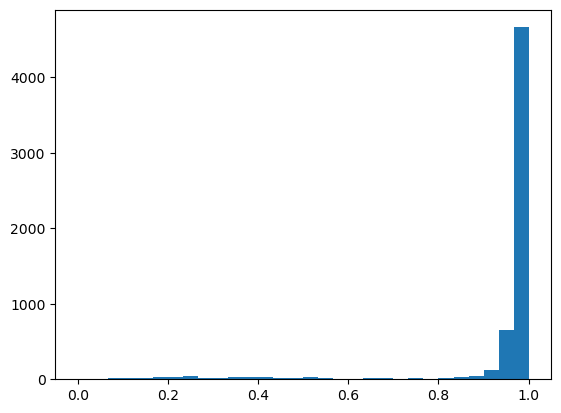

In [ ]:
plt.hist(full_ratio.welfare_ratio, bins=30, range=[0, full_ratio.welfare_ratio.max()])